In [1]:
location_names = [
"المنشية", "يتسهار", "صرة", "زعترة", "عصيرة", "المساكن", "المربعة",
"بوابة بورين", "دير شرف", "عورتا", "بيت فوريك", "بزاريا", "شافي شمرون",
"حومش", "عناب", "الكفريات", "حجة", "وادي قانا", "بيت ليد", "كفر لاقف",
"الحمرا", "عوفرا", "ارئيل", "سلفيت", "رام الله", "نابلس", "عين سينيا",
"عطارة", "روابي", "عيون الحرامية", "ترمسعيا", "سنجل", "كركر", "بيت ايل",
"عزون", "جماعين", "كفل حارس", "مردا", "اللبن الشرقية", "بديا", "برقين",
"الزعيم", "العيزرية", "قلنديا", "جبع", "الكونتينر", "عش الغراب",
"مخماس", "جيت", "بيتا", "دير بلوط", "ياسوف", "النبي الياس", "سعير",
"حلحول", "حوارة", "راس الجورة", "عناتا", "حزما", "اماتين", "بيرزيت",
"النبي صالح", "افرات", "تقوع", "دورا", "عتصيون", "العروب", "فرش الهوى",
"حاجز النفق", "شارع بيجن", "الخليل", "واد النار", "DCO", "بيت جالا",
"اريحا", "برقة", "الغرس", "يتما", "الساوية", "يبرود", "سلواد",
"الطيبة", "النشاش", "طولكرم", "المسعودية", "بيت ايل", "جنين",
"قلقيلية", "عيلي", "كدوميم", "مخيم الجلزون", "روجيب", "شعفاط",
"الرام", "بيت لحم", "حوارة", "قبلان", "عينبوس", "بيت عور", "القرع",
"اودلا", "معالي ادوميم", "حزما", "السيلة", "نور شمس", "بلعا",
"الجفتلك", "الباذان", "البيرة", "بركان", "حبلة", "حرميش", "طوباس",
"السيلة", "افرايم", "ضواحي القدس", "القدس", "العبيدية", "بيت ساحور",
"تل الربيع", "يطا", "الظاهرية", "ترقوميا", "دير شرف", "شقبا",
"النفق", "شيلو", "عطروت", "حلميش", "المشتل", "عقربا", "قلنديا",
"سبسطية", "الفوار", "ادوميم", "العبيدية", "جين صافوت", "زواتا",
"حومش", "دير استيا", "العوجا", "بيت امر", "قباطية", "الجلزون",
"عطارة", "الخروبة", "عارورة", "الاحراش", "عصيرة الشمالية", "جيوس", "عين يبرود",
"عنبتا", "الناقورة", "الدهيشة", "بيت امرين", "قوصين", "عناتا",
"باب الزاوية", "الصيرفي", "صوريف", "ضاحية الريحان", "ابو ديس", "سالم",
"العيسوية", "بيت حنينا", "البيرة", "الاسكانات", "الزاوية", "النصارية",
"واد قانا", "المصانع", "كفر عقب", "بير زيت", "عصيرة القبلية", "الفندق"
]

close_words = [
'مغلق', 'مغلقة', 'وقوف', 'واقفه', 'سكروه', 'مسكره', 'سكر',
'مسكرين', 'متوقفه', 'اغلاق', 'اغلاقه'
]
open_words = [
'فتح', 'فاضي', 'سالك', 'سالكه', 'فاتحة', 'فاتح', 'سلك', 'فتحت',
'فاتحين', 'بمشو', 'مفتوحة', 'بسلك', 'بمشي', 'مشوا', 'فتحوها', 'سالكات', 'وسلك'
]

In [2]:
import re
from rapidfuzz import fuzz



def preprocess_and_tokenize(data, location_names, close_words, open_words, similarity_threshold=80, close_threshold=80, open_threshold=80):
    # Remove emojis from the text
    def remove_emojis(text):
        if isinstance(text, str):
            return re.sub(r'[^\w\s,.!?؛:\n]', '', text)
        return text

    data['message'] = data['message'].apply(remove_emojis)
    
    # Function to remove jargon terms
    def remove_jargon(data, jargon_terms):
        def clean_message(message):
            pattern = re.compile(r'\b(' + '|'.join(re.escape(term) for term in jargon_terms) + r')\b', re.IGNORECASE)
            return pattern.sub('', message)
        
        data['message'] = data['message'].apply(clean_message)
        data['message'] = data['message'].str.strip().replace(r'\s+', ' ', regex=True)
        return data
    
    # Tokenization function with similarity checks
    def regex_tokenize_with_similarity(data, location_names, similarity_threshold=80, close_threshold=80, open_threshold=80):
        sentence_splitter = re.compile(r'(?<=[.!?]) +')
        word_splitter = re.compile(r'[\u0600-\u06FF]+|\d+|\w+')

        sentences_list = []
        words_list = []
        original_messages = []
        word_indices = []
        labels = []
        similarities = []
        sentence_count = 1

        for index, message in data['message'].items():
            if isinstance(message, str):
                sentences = sentence_splitter.split(message.strip())
                for sentence in sentences:
                    words = word_splitter.findall(sentence)

                    i = 0
                    while i < len(words):
                        if i + 1 < len(words) and f"{words[i]} {words[i+1]}" in location_names:
                            labels.extend(["B-LOC", "I-LOC"])
                            similarities.extend([100, 100])

                            sentences_list.extend([f"Sentence: {sentence_count} (Message {index})"] * 2)
                            words_list.extend([words[i], words[i + 1]])
                            original_messages.extend([message] * 2)
                            word_indices.extend([i + 1, i + 2])

                            i += 2
                            continue
                        elif words[i] in location_names:
                            labels.append("B-LOC")
                            similarities.append(100)
                        else:
                            max_close_similarity = max(fuzz.ratio(words[i], word) for word in close_words)
                            if max_close_similarity >= close_threshold:
                                labels.append("B-close")
                                similarities.append(max_close_similarity)
                            else:
                                max_open_similarity = max(fuzz.ratio(words[i], word) for word in open_words)
                                if max_open_similarity >= open_threshold:
                                    labels.append("B-open")
                                    similarities.append(max_open_similarity)
                                else:
                                    max_loc_similarity = max(fuzz.ratio(words[i], loc) for loc in location_names)
                                    labels.append("B-LOC" if max_loc_similarity >= similarity_threshold else "O")
                                    similarities.append(max_loc_similarity if max_loc_similarity >= similarity_threshold else 0)

                        sentences_list.append(f"Sentence: {sentence_count} (Message {index})")
                        words_list.append(words[i])
                        original_messages.append(message)
                        word_indices.append(i + 1)
                        i += 1

                    sentence_count += 1
            else:
                print(f"Warning: Message at index {index} is not a string. Skipping...")

        tokenized_df = pd.DataFrame({
            'Sentence #': sentences_list,
            'Word': words_list,
            'Original Message': original_messages,
            'Word Index': word_indices,
            'label': labels,
            'Similarity Score': similarities
        })

        return tokenized_df

    # Preprocess the data and tokenize with similarity
    data = remove_jargon(data, [])  # Pass any jargon terms to remove if necessary
    tokenized_df = regex_tokenize_with_similarity(data, location_names, similarity_threshold, close_threshold, open_threshold)

    # Extract sentence and message information
    tokenized_df[['Sentence', 'Message']] = tokenized_df['Sentence #'].str.extract(r'Sentence: (\d+) \(Message (\d+)\)')
    tokenized_df = tokenized_df.drop(columns=['Sentence #'])
    tokenized_df['Word Length'] = tokenized_df['Word'].apply(len)
    
    return tokenized_df



In [3]:
from catboost import CatBoostClassifier

load_catboost = CatBoostClassifier()

In [4]:
load_catboost.load_model('/teamspace/studios/this_studio/ROADWATCH/Road/catboost_model_98.cbm')

In [6]:
import pandas as pd

data = pd.read_csv('/teamspace/studios/this_studio/filtered_messages.csv')

In [7]:
data

,id,date,sender_id,message
0,1715452,2024-11-23T12:28:39+00:00,6.415259e+09,عش الغراب أزمة للداخل على بيت لحم
1,1715451,2024-11-23T12:21:22+00:00,6.415259e+09,الكونتير ازمه وشبه مغلق
2,1715450,2024-11-23T12:20:34+00:00,5.085060e+08,الوضع صعب جدا على عورتا للداخل ⛔️⛔️⛔️⛔️⛔️⛔️⛔️⛔️
3,1715449,2024-11-23T12:18:08+00:00,5.085060e+08,حاجز معالي افرايم سالك بالاتجاهين✅✅✅
4,1715448,2024-11-23T12:15:19+00:00,6.415259e+09,تم فتح حاجز عناب بالاتجاهين ✅✅✅
...,...,...,...,...
32997,1675662,2024-08-24T23:25:30+00:00,6.635080e+09,تحديث ارقام مجمعات تكاسي بين المدن\n\nرقم كراج...
32998,1675661,2024-08-24T23:25:14+00:00,6.635080e+09,في حال انقطاعك بجميع طرق الضفه::::\nارقام الون...
32999,1350761,2023-11-08T17:55:52+00:00,6.715279e+09,أرقام كراجات المدن
33000,568836,2023-04-13T19:37:30+00:00,5.970923e+09,🚌ارقام مجمعات تكاسي بين المدن::::\n📞رقم كراجات...


In [8]:
tokenized_df = preprocess_and_tokenize(data, location_names, close_words, open_words)


In [9]:
tokenized_df

,Word,Original Message,Word Index,label,Similarity Score,Sentence,Message,Word Length
0,عش,عش الغراب أزمة للداخل على بيت لحم,1,B-LOC,100.0,1,0,2
1,الغراب,عش الغراب أزمة للداخل على بيت لحم,2,I-LOC,100.0,1,0,6
2,أزمة,عش الغراب أزمة للداخل على بيت لحم,3,O,0.0,1,0,4
3,للداخل,عش الغراب أزمة للداخل على بيت لحم,4,O,0.0,1,0,6
4,على,عش الغراب أزمة للداخل على بيت لحم,5,O,0.0,1,0,3
...,...,...,...,...,...,...,...,...
308864,العسل,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,35,O,0.0,33836,33001,5
308865,0569317865,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,36,O,0.0,33836,33001,10
308866,ونشات,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,37,O,0.0,33836,33001,5
308867,الجبعي,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,38,O,0.0,33836,33001,6


In [18]:
tokenized_df['label'] = tokenized_df['label'].replace('I-LOC', 'B-LOC')
tokenized_df['label'] = tokenized_df['label'].replace({'B-open': 'B-STATE', 'B-close': 'B-STATE'})


In [19]:
tokenized_df.isnull().sum()

Word                0
Original Message    0
Word Index          0
label               0
Similarity Score    0
Sentence            0
Message             0
Word Length         0
Predicted Label     0
dtype: int64

In [26]:
X = tokenized_df[['Word']]


AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [28]:
predictions = load_catboost.predict(X)


In [29]:
tokenized_df['Predicted Label'] = predictions


In [30]:
tokenized_df

,Word,Original Message,Word Index,label,Similarity Score,Sentence,Message,Word Length,Predicted Label
0,عش,عش الغراب أزمة للداخل على بيت لحم,1,B-LOC,100.0,1,0,2,B-LOC
1,الغراب,عش الغراب أزمة للداخل على بيت لحم,2,B-LOC,100.0,1,0,6,B-LOC
2,أزمة,عش الغراب أزمة للداخل على بيت لحم,3,O,0.0,1,0,4,O
3,للداخل,عش الغراب أزمة للداخل على بيت لحم,4,O,0.0,1,0,6,O
4,على,عش الغراب أزمة للداخل على بيت لحم,5,O,0.0,1,0,3,O
...,...,...,...,...,...,...,...,...,...
308864,العسل,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,35,O,0.0,33836,33001,5,O
308865,0569317865,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,36,O,0.0,33836,33001,10,O
308866,ونشات,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,37,O,0.0,33836,33001,5,O
308867,الجبعي,في حال انقطاعك بجميع طرق الضفه:::: ارقام الونش...,38,O,0.0,33836,33001,6,O


In [33]:
# View predicted labels
tokenized_df[['Word', 'label', 'Predicted Label']].head(25)


,Word,label,Predicted Label
0,عش,B-LOC,B-LOC
1,الغراب,B-LOC,B-LOC
2,أزمة,O,O
3,للداخل,O,O
4,على,O,O
5,بيت,B-LOC,B-LOC
6,لحم,B-LOC,B-LOC
7,الكونتير,B-LOC,B-LOC
8,ازمه,O,O
9,وشبه,O,O


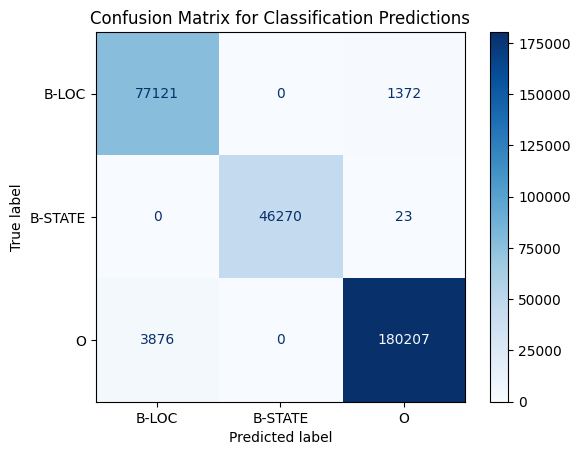

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(tokenized_df['label'], tokenized_df['Predicted Label'], labels=load_catboost.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=load_catboost.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Classification Predictions')
plt.show()


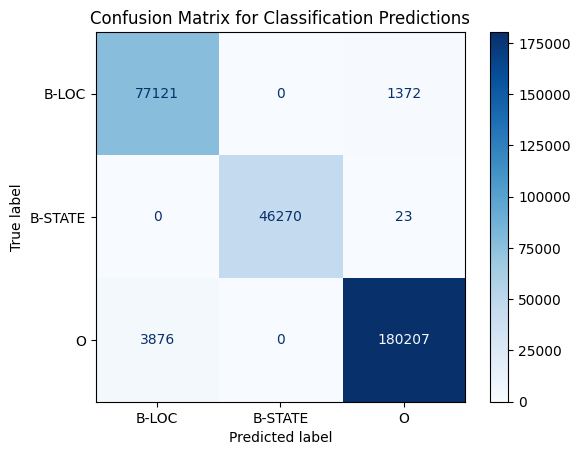

In [36]:
# Save the confusion matrix plot to a file
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Classification Predictions')
plt.savefig('/teamspace/studios/this_studio/ROADWATCH/Test-Model/test-Catboost/visualization/confusion_matrix.png')
